# **Assignment 1**, **dataset 2**


# Problem statement

Statlog (German Credit Data)

https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data <-- Refer to the documentation for the details that are not mentioned here

This dataset classifies people described by a set of attributes as good or bad credit risks. The dataset uses codes to describe the categorigal attributes. Make sure to deal with those appropriatelly. See the documentation link above.

Cost Matrix

This dataset requires use of a cost matrix (see below)




|   | 1 | 2 |
|---|---|---|
| 1 | 0 | 1 |
| 2 | 5 | 0 |

(1 = Good,  2 = Bad)

the rows represent the actual classification and the columns
the predicted classification.

It is worse to class a customer as good when they are bad (cost 5),
than it is to class a customer as bad when they are good (cost 1).

Make sure to include this information when reporting your results


### Loading the dataset

In [1]:
!pip install ucimlrepo

In [2]:
# You are free to use this code snippet in your Python environment or download the dataset manually and load into the notebook.
from ucimlrepo import fetch_ucirepo

# fetch dataset
credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = credit_data.data.features
y = credit_data.data.targets

# metadata
print(credit_data.metadata)

# variable information
print(credit_data.variables)

# Make sure to split the data for validation (I do that later)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

## **Exploratory Data Analysis**

The student will have to make a written analysis of the data being loaded (depending on the dataset that was assigned to them). They should apply methods of inspecting the data and make some exploratory data analysis

In [3]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


As we can see above, the dataset consists of 20 attributes based on which people can be classified as good or bad credit risks. The dependent variable therefore is whether the person is a good (value of 1) or bad (value of 2) credit risk and the attributes are the independent variables. The problem at hand is framed as a binary classification. Since the attributes are just numbered, in the first step, I replaced the current column names with their (shortened) descritption to facilitate the exploratory data analysis.

In [4]:
name_map = dict(zip(credit_data.variables['name'], credit_data.variables['description']))
X = X.rename(columns=name_map)
X.columns

Index(['Status of existing checking account', 'Duration', 'Credit history',
       'Purpose', 'Credit amount', 'Savings account/bonds',
       'Present employment since',
       'Installment rate in percentage of disposable income',
       'Personal status and sex', 'Other debtors / guarantors',
       'Present residence since', 'Property', 'Age', 'Other installment plans',
       'Housing', 'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for', 'Telephone',
       'foreign worker'],
      dtype='object')

In [5]:
print(X.columns)
shortened_names = {
    'Installment rate in percentage of disposable income': 'Installment rate',
    'Number of existing credits at this bank': 'No credits',
    'Number of people being liable to provide maintenance for': 'No Dependents'
}
X = X.rename(columns=shortened_names)

Index(['Status of existing checking account', 'Duration', 'Credit history',
       'Purpose', 'Credit amount', 'Savings account/bonds',
       'Present employment since',
       'Installment rate in percentage of disposable income',
       'Personal status and sex', 'Other debtors / guarantors',
       'Present residence since', 'Property', 'Age', 'Other installment plans',
       'Housing', 'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for', 'Telephone',
       'foreign worker'],
      dtype='object')


In [6]:
X.head()

,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,No credits,Job,No Dependents,Telephone,foreign worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [7]:
y.iloc[0] # label of first data point

,0
class,1


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Status of existing checking account  1000 non-null   object
 1   Duration                             1000 non-null   int64 
 2   Credit history                       1000 non-null   object
 3   Purpose                              1000 non-null   object
 4   Credit amount                        1000 non-null   int64 
 5   Savings account/bonds                1000 non-null   object
 6   Present employment since             1000 non-null   object
 7   Installment rate                     1000 non-null   int64 
 8   Personal status and sex              1000 non-null   object
 9   Other debtors / guarantors           1000 non-null   object
 10  Present residence since              1000 non-null   int64 
 11  Property                             1000 no

Above, we have a look at the first five rows (=individuals to classify as good or bad credit risks). The first individual is classified as good credit risk based on the following attributes:

- Status of existing checking account: A11 (< 0 DM)

- Duration: 6 months

- Credit history: A34 (critical account/  other credits existing (not at this bank))

- Purpose: A43 (radio/television), person takes the credit to buy a radio or television

- Credit amount: 1169

- Savings account/bonds: A65 (unknown/ no savings account)

- Present employment since: A75 (>= 7 years)

- Installment rate: 4 % of percentage of disposable income

- Personal status and sex: A93 (male, single)

- Other debtors / guarantors: A101 (none)

- Present residence since: 4

- Property: A121 (real estate)

- Age: 67

- Other installment plans: A143 (none)

- Housing: A152 (own)

- No credits: 2

- Job: A173 (skilled employee / official)

- No Dependents: 1 person being liable to provide maintenance for

- Telephone: A192 (none)

- foreign worker: A201 (yes)



We can see that we have no nan values, and 7 numerical or continuous attributes and 13 categorical variables that are expressed as codes, e.g. the attribute "Telephone" describes whether there is a telephone number registered under the customers name (value of A192) or not (A191). For the numerical values, we can conduct some basic statistics. Below, we can for example see that the average age is 35 years and the average credit amount is 3271.26 DM. We also see that age has a smaller scale than for example credit amount and depending on the algorithm we use, it might therefore be crucial to normalize the data if the algorithm/ML method is sensitive to the scale of the data QUOTE

In [9]:
X.describe() # inspect the numerical values. For scale sensitive algorithms normalization might be applicable.

,Duration,Credit amount,Installment rate,Present residence since,Age,No credits,No Dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


For the numerical values, we can plot pairwise relationships/patterns between variables and visualize their distributions (in the diagonals). We observe for example that the majority of people taking credits is between 20 and 40, and "Duration" and "Credit amount" seem to be positively correlated. A correlation or pattern for the credit risk target variable is not clearly detectable. We can further observe that the dataset is imbalanced since the majority of datapoints are labeled as good credit risk.

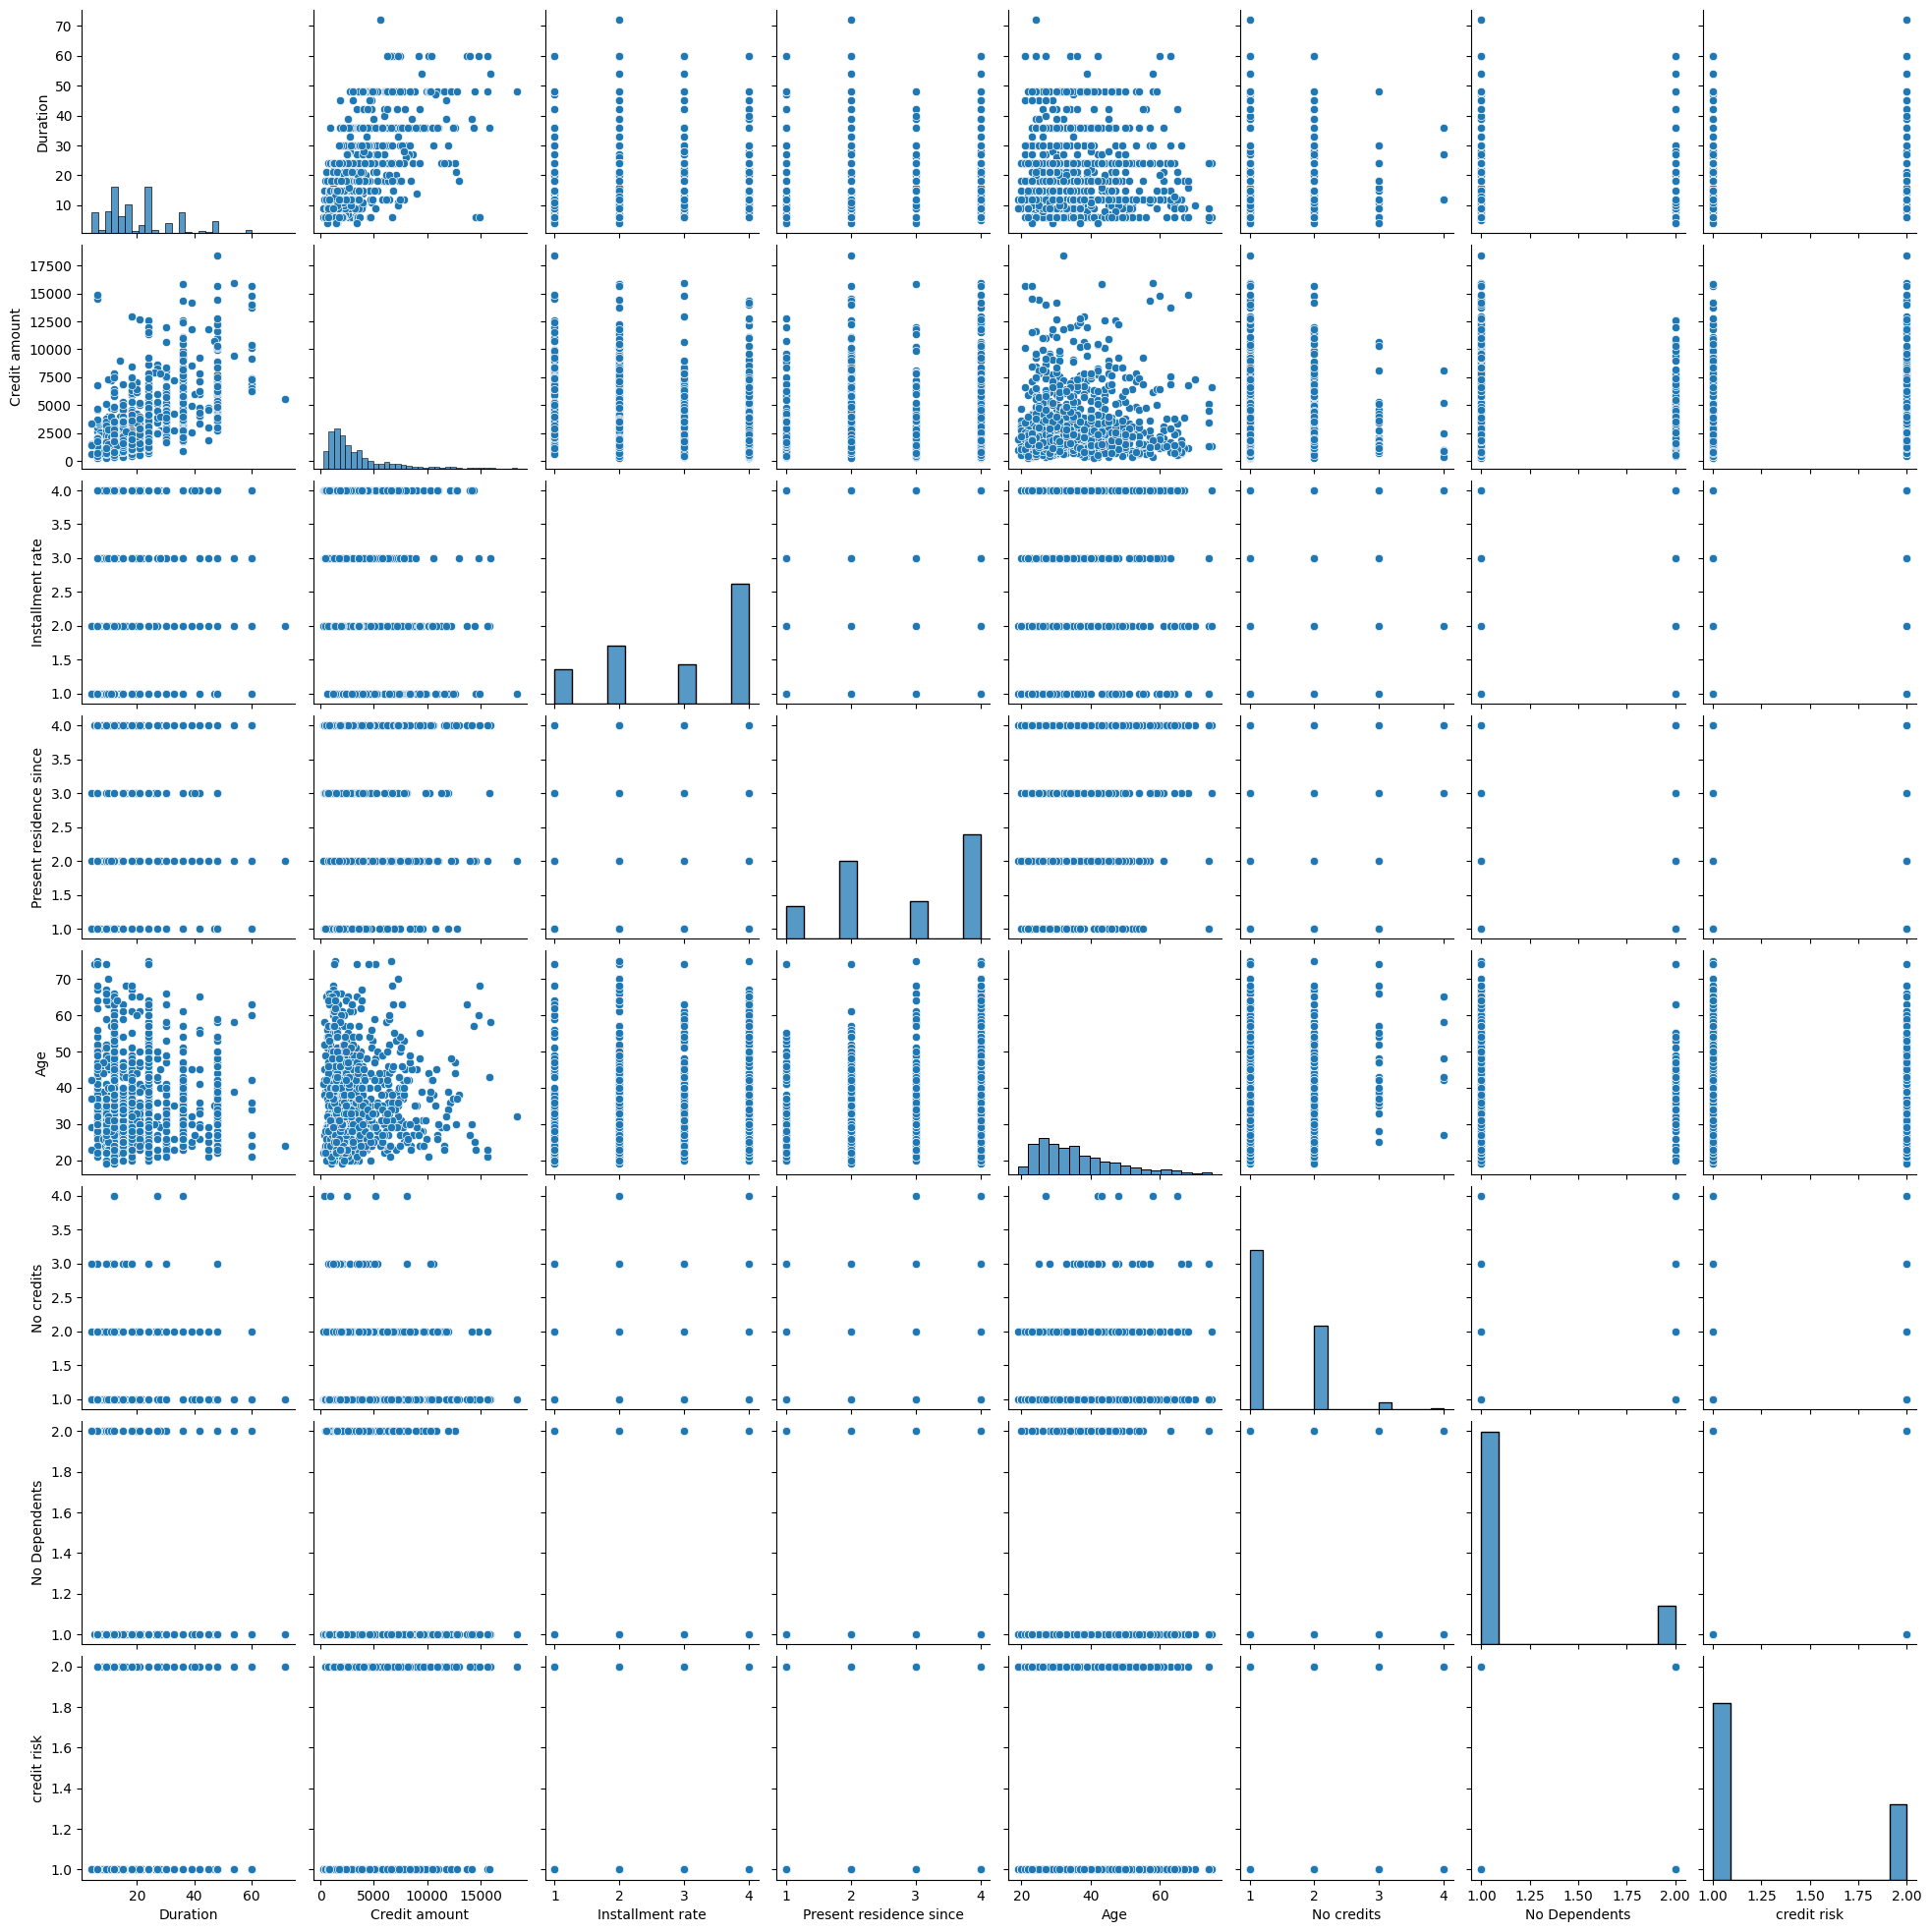

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
df = X.copy()
df['credit risk'] = y["class"]
# sns.pairplot(df, hue="credit risk")
sns.pairplot(df)
plt.show()

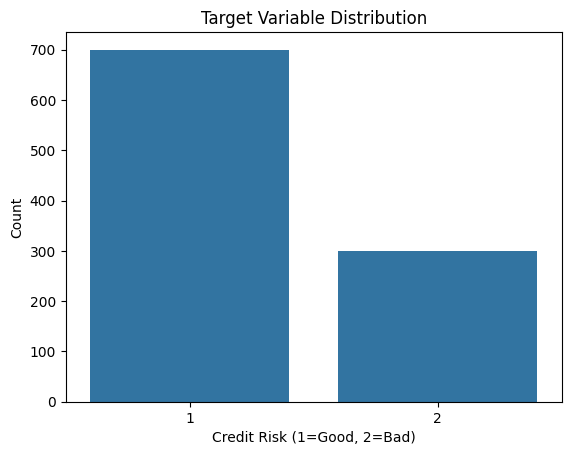

In [11]:
sns.countplot(x=df["credit risk"])
plt.title("Target Variable Distribution")
plt.xlabel("Credit Risk (1=Good, 2=Bad)")
plt.ylabel("Count")
plt.show()
# y.value_counts()

For binary classification, it is further crucial to convert the labels into 0 (bad credit risk) and 1 (good credit risk) to make it more interpretable and QUOTE.

In [12]:
df["credit risk"] = df["credit risk"].replace(2, 0)

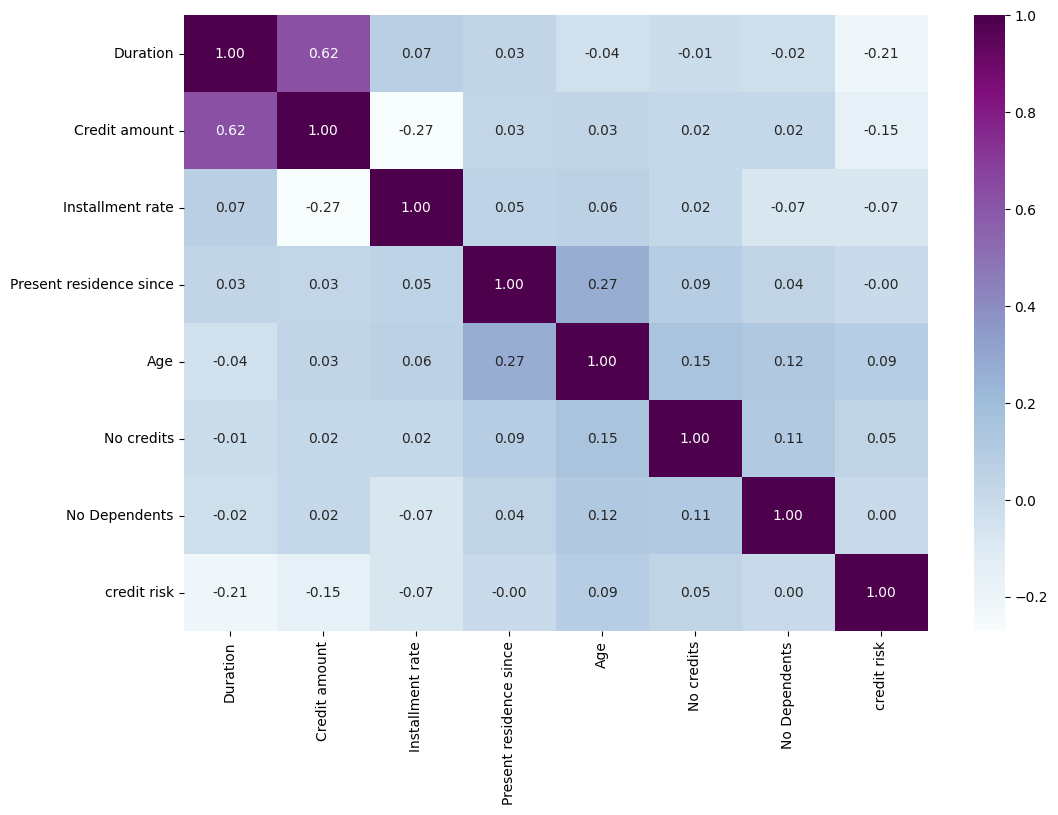

In [13]:
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".2f")
plt.show()

Above we can see that there is a slight negative correlation between credit risk (target variable) and duration (-0.21), indicating that longer durations are more likely bad credit risks, and between credit amount and credit risk (-0.15), indicating that larger credit amounts increase the classification as bad credit risk. A very slight positive correlation is observable between age and credit risk (0.09). There is no correlation at all between "No Dependents" and "present residence since". Furthermore, between the independent variables, there is a positive correlation between credit amount and duration (0.62, multicollinearity!), and a moderately positive correlation between age and "present residence since".

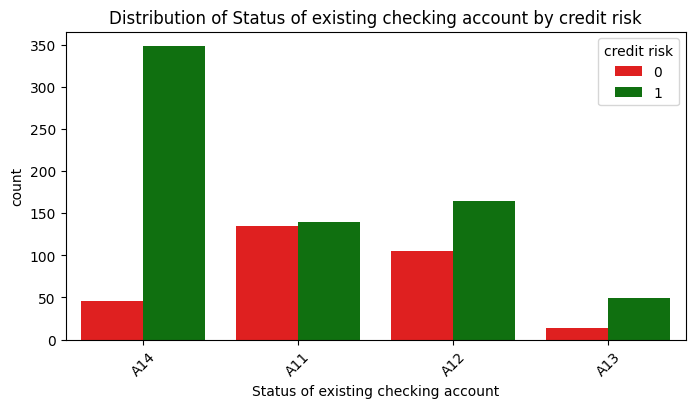

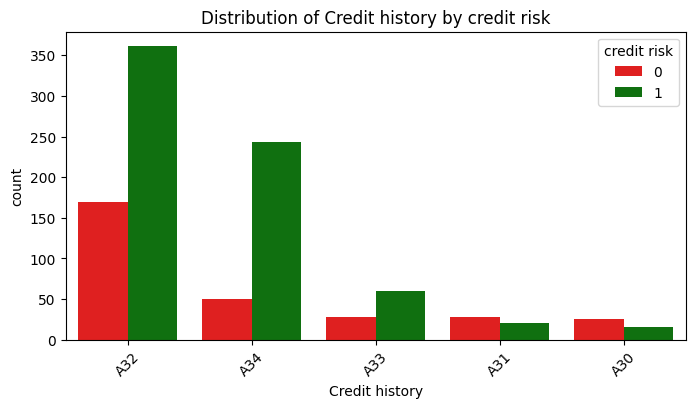

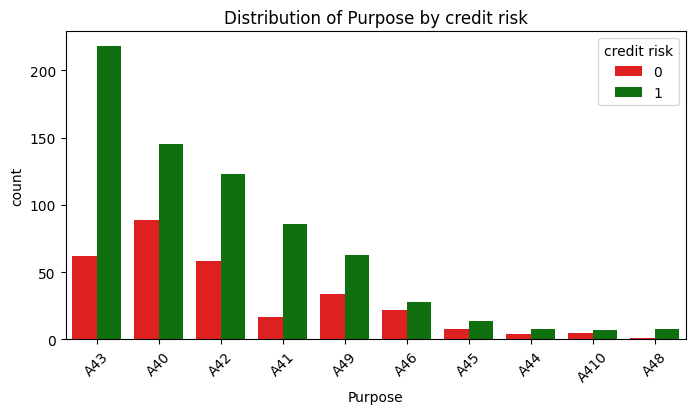

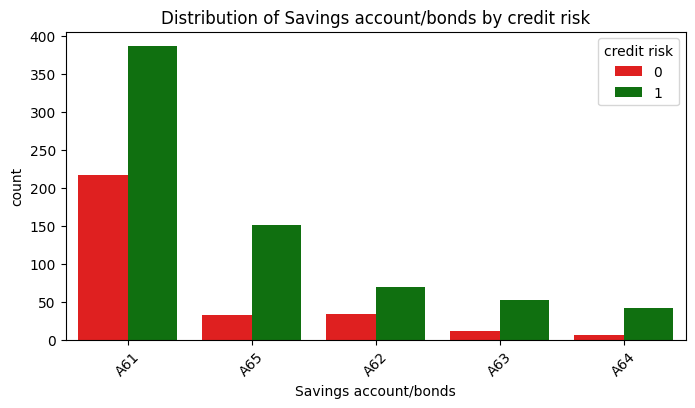

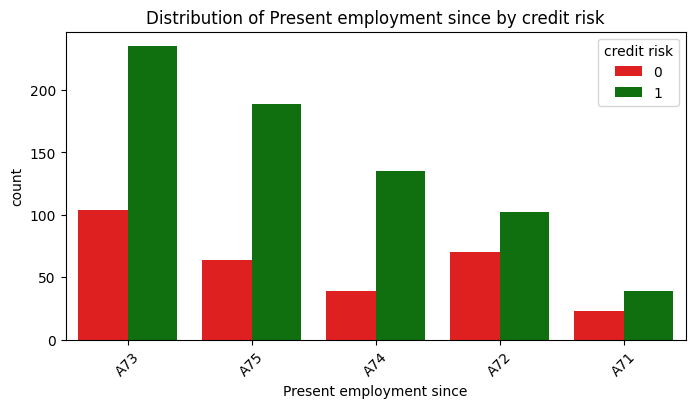

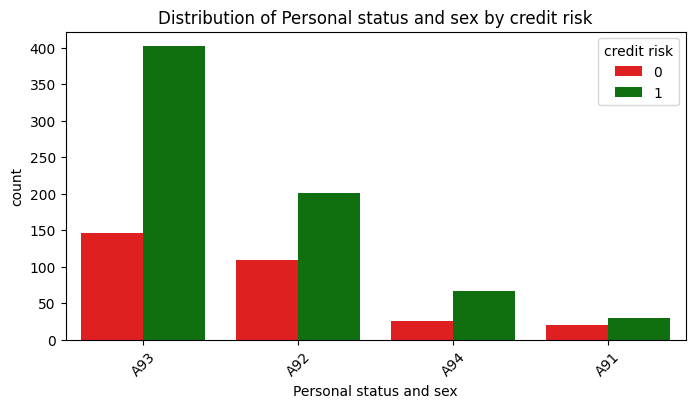

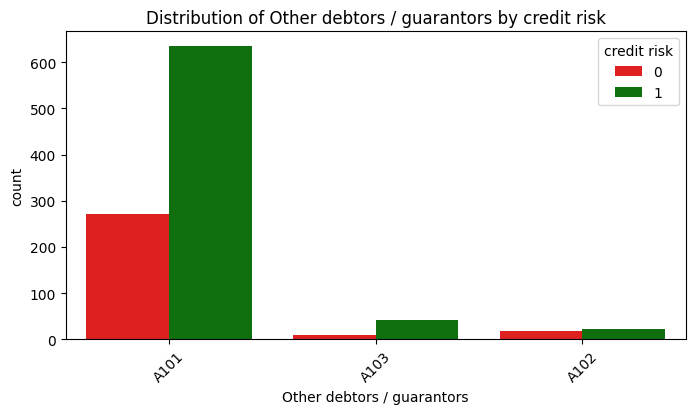

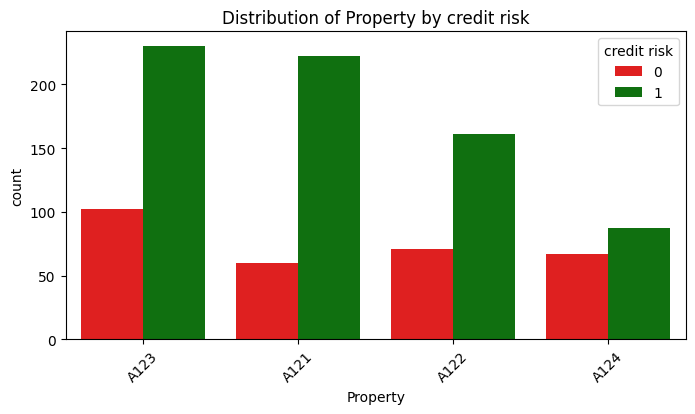

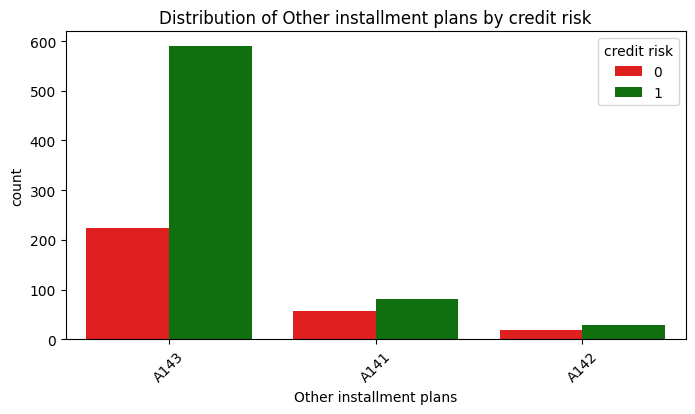

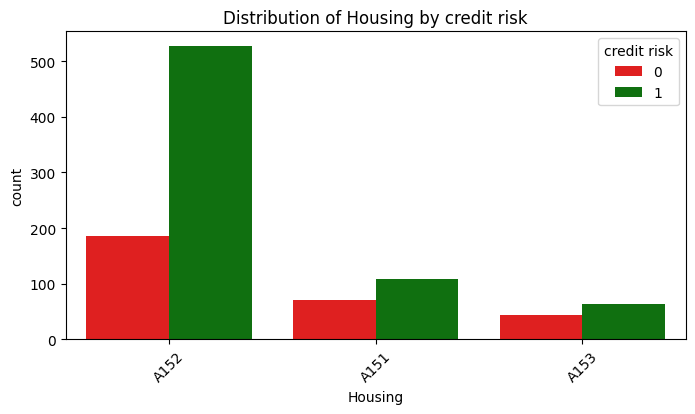

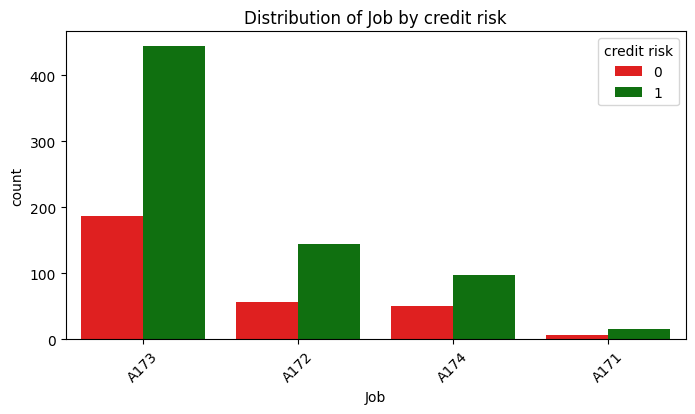

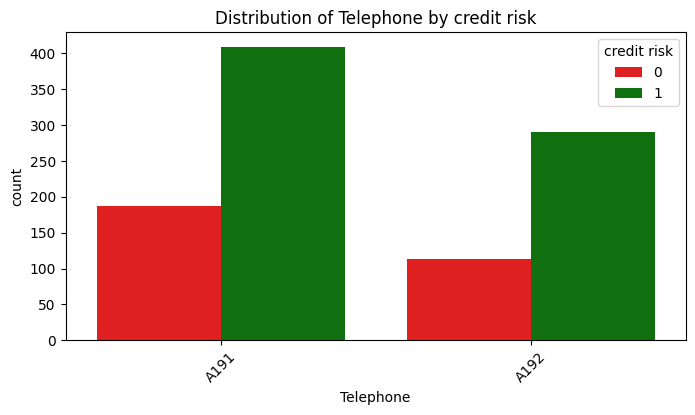

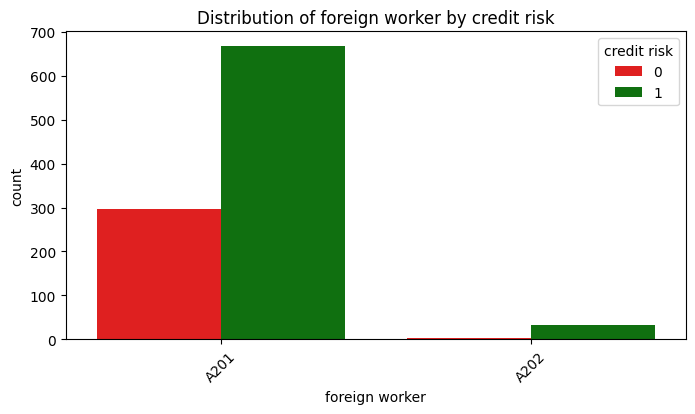

In [20]:
palette = {1: 'green', 0: 'red'}

for col in df.select_dtypes(include='object').columns: # check categorical values
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='credit risk', data=df, order=df[col].value_counts().index, palette=palette)
    plt.title(f"Distribution of {col} by credit risk")
    plt.xticks(rotation=45)
    plt.show()

# WHICH COLUMNS TO DROP?

## **Data Preprocessing**:

If applicable, the student will create new features from existing data to improve model performance and/or select the most relevant features for the model.

-  Drop columns that represent noise
- convert labels for binary classification
- create new features?
- augmentation more applicable to images or text, here, i would not do it. Might be worth trying out undersampling because target classes are imbalanced.

In [70]:
# convert labels for binary classification
print(y["class"].unique())
y["class"] = y["class"].replace(2, 0)
print(y["class"].unique())

# drop Telephone column
X.drop(['Job'], axis=1, inplace=True) # drop telephone, no dependents

[1 0]
[1 0]


/tmp/ipython-input-443509665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["class"] = y["class"].replace(2, 0)


## **Data Transformation**

The student should prepare the data for the training. Augmenting, splitting, and otherwise transforming should be done here.

- splitting
- scaling
- converting catergorical to numerical

In [71]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from sklearn.compose import ColumnTransformer

# converting categorical to numerical values and scale numerical values
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns # we want to scale only the numerical values


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


X_transformed = preprocessor.fit_transform(X)
X_transformed.shape

(1000, 54)

In [112]:
# Access the fitted OneHotEncoder inside the ColumnTransformer
ohe = preprocessor.named_transformers_['cat']

# Get feature names for the one-hot encoded categorical columns
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

# For numerical columns, just use their original names
num_feature_names = numerical_cols.tolist()

# Combine them in the order they appear after transformation
all_feature_names = num_feature_names + list(ohe_feature_names)

print(all_feature_names)

['Duration', 'Credit amount', 'Installment rate', 'Present residence since', 'Age', 'No credits', 'Status of existing checking account_A11', 'Status of existing checking account_A12', 'Status of existing checking account_A13', 'Status of existing checking account_A14', 'Credit history_A30', 'Credit history_A31', 'Credit history_A32', 'Credit history_A33', 'Credit history_A34', 'Purpose_A40', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49', 'Savings account/bonds_A61', 'Savings account/bonds_A62', 'Savings account/bonds_A63', 'Savings account/bonds_A64', 'Savings account/bonds_A65', 'Present employment since_A71', 'Present employment since_A72', 'Present employment since_A73', 'Present employment since_A74', 'Present employment since_A75', 'Personal status and sex_A91', 'Personal status and sex_A92', 'Personal status and sex_A93', 'Personal status and sex_A94', 'Other debtors / guarantors_A101', 'Othe

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_eval shape:", X_eval.shape)
print("y_train shape:", y_train.shape)
print("y_eval shape:", y_eval.shape) # rename into VAL!


X_train_processed = preprocessor.transform(X_train)
X_eval_processed = preprocessor.transform(X_eval)

X_train shape: (800, 17)
X_eval shape: (200, 17)
y_train shape: (800, 1)
y_eval shape: (200, 1)


## **Model Selection**


The student should implement a simple model as a baseline to compare more complex models. The student should try more complex modes and justify their rejection or acceptance.

As a simple baseline I chose logistic regression since ...
As a more complex model I chose
I did not choose a neural network since the data is a rather small data set (1000 rows) and it would be an overkill.

In [108]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=1000) # class weight balanced makes it slightly worse? But cost reduced? USE COST MATRIX
model.fit(X_train_processed, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [109]:
print("Train score:", model.score(X_train_processed, y_train))
print("Eval score:", model.score(X_eval_processed, y_eval))

Train score: 0.78125
Eval score: 0.795


150
50
              precision    recall  f1-score   support

           0       0.68      0.58      0.62        59
           1       0.83      0.89      0.86       141

    accuracy                           0.80       200
   macro avg       0.76      0.73      0.74       200
weighted avg       0.79      0.80      0.79       200

[[ 34  25]
 [ 16 125]]
AUC: 0.8178867652362063


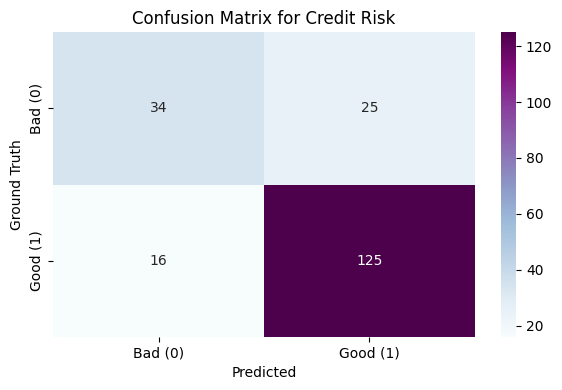

In [110]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

y_pred = model.predict(X_eval_processed)
print(np.sum(y_pred == 1))
print(np.sum(y_pred == 0))

print(classification_report(y_eval, y_pred))
print(confusion_matrix(y_eval, y_pred))
print("AUC:", roc_auc_score(y_eval, model.predict_proba(X_eval_processed)[:, 1]))

cm = confusion_matrix(y_eval, y_pred)
#print(cm)

#tn, fp, fn, tp = cm.ravel()

#total_cost = (fp * 5) + (fn * 1)
#print("Total Misclassification Cost:", total_cost)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=["Bad (0)", "Good (1)", ], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix for Credit Risk')
plt.tight_layout()
plt.show()

# The model is predicting in 26 cases that the person poses no credit risk even though the person does, and FPs are more costly. This might be due to imbalanced data set or because some features introduced noise.
# We also see that half of the bad credit risk are classified as good which has high cost...

In [104]:
### Now gradient boosting, USE OPTUNA FOR NUM_LEAVES, LR
import lightgbm as lgb

train_data = lgb.Dataset(X_train_processed, label=y_train)
val_data = lgb.Dataset(X_eval_processed, label=y_eval)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': True, # reduced performance, potentially because class imbalance is not severe?
    'boosting': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 8,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.9
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
)


y_pred = model.predict(X_eval_processed)
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_eval, y_pred_labels))
roc_auc = roc_auc_score(y_eval, y_pred)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y_eval, y_pred_labels))


              precision    recall  f1-score   support

           0       0.73      0.59      0.65        59
           1       0.84      0.91      0.87       141

    accuracy                           0.81       200
   macro avg       0.79      0.75      0.76       200
weighted avg       0.81      0.81      0.81       200

ROC AUC Score: 0.8123572544777018
Confusion Matrix:
[[ 35  24]
 [ 13 128]]


Simpler seems to be better here... Let's try out a decision tree and then random forest.

In [ ]:
# lightgbm without one hot encoding, SPLIT might be wrong?


In [119]:
# decision tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
decision_tree_model = DecisionTreeClassifier(max_depth = 5, class_weight='balanced', criterion = 'entropy')
decision_tree_model.fit(np.array(X_train_processed), np.array(y_train)
)

y_pred_proba = model.predict_proba(X_eval_processed)[:, 1]
y_pred = decision_tree_model.predict(X_eval_processed)

print("Classification Report:")
print(classification_report(y_eval, y_pred))

roc_auc = roc_auc_score(y_eval, y_pred_proba)
print("ROC AUC Score:", roc_auc)


print("Confusion Matrix:")
print(confusion_matrix(y_eval, y_pred))
# feature importances
print(decision_tree_model.feature_importances_)

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.90      0.61        59
           1       0.93      0.55      0.69       141

    accuracy                           0.66       200
   macro avg       0.69      0.73      0.65       200
weighted avg       0.79      0.66      0.67       200

ROC AUC Score: 0.8178867652362063
Confusion Matrix:
[[53  6]
 [63 78]]
[1.31560731e-01 1.24507089e-01 0.00000000e+00 0.00000000e+00
 1.51256657e-01 0.00000000e+00 4.41819354e-02 0.00000000e+00
 2.49943437e-02 2.56189307e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.45198141e-02
 0.00000000e+00 0.00000000e+00 1.27416638e-02 1.79764980e-02
 0.00000000e+00 3.62270734e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.50189337e-02
 0.00000000e+00 2.57755709e-02 0.00000000e+00 0.00000000e+00
 5.33607547e-16 3.10878345e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00

In [101]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced',random_state=0)

model.fit(X_train_processed, y_train)

y_pred = model.predict(X_eval_processed)
y_pred_proba = model.predict_proba(X_eval_processed)[:, 1]


print(classification_report(y_eval, y_pred))

# ROC AUC score
roc_auc = roc_auc_score(y_eval, y_pred_proba)
print("ROC AUC Score:", roc_auc)
print(confusion_matrix(y_eval, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.57      0.73      0.64        59
           1       0.87      0.77      0.82       141

    accuracy                           0.76       200
   macro avg       0.72      0.75      0.73       200
weighted avg       0.78      0.76      0.76       200

ROC AUC Score: 0.8211323476379372
[[ 43  16]
 [ 33 108]]


## **Reporting the results**

The student should report the results. Identify which features are most influential in the model’s predictions, if applicable for the dataset and model used.

In [116]:
coefficients = model.coef_[0] # check coefficients of the model to check which features are most important. HOW TO MAP BACK FROM ONE HOT ENCODING, HANDLE CLASS IMBALANCE --> because classifying bad as good is costly and it might be also due to positive being majority class
print(coefficients) # I guess for decision trees it might also be interesting to visualize them. USE BOOK FOR REFERENCES, VISUALIZE ROC CURVES

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients) # THESE ARE LINEAR RELATIONSHIPS
})

coef_df_sorted = coef_df.sort_values(by='abs_coefficient', ascending=False)
print(coef_df_sorted[['feature', 'coefficient']])

[-0.27270603 -0.30167506 -0.33274093 -0.02999399  0.33149727 -0.18482486
 -0.75901585 -0.31193169  0.26239336  0.80818456 -0.5807547  -0.52873935
 -0.02078094  0.33769844  0.79220693 -0.69926507  0.79551947  0.23261747
  0.194398    0.21606577 -0.11787859 -0.28611244 -0.8322872   0.55778577
 -0.0612128  -0.41538865 -0.30124503  0.02234729  0.42549235  0.26842443
 -0.14189452 -0.11278379 -0.14818687  0.32952112  0.07297443 -0.40798859
 -0.01801249  0.44566789 -0.02003644 -0.23913488 -0.24753333  0.48629858
  0.26621098 -0.04726437  0.03061833 -0.24993457 -0.31927131 -0.08101345
  0.39991514 -0.24850123  0.28499675 -0.03686515 -0.53601822  0.5356486 ]
                                    feature  coefficient
22                              Purpose_A46    -0.832287
9   Status of existing checking account_A14     0.808185
16                              Purpose_A41     0.795519
14                       Credit history_A34     0.792207
6   Status of existing checking account_A11    -0.759016


In [121]:
feature_importances = decision_tree_model.feature_importances_

feature_importances_dt_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
})

feature_importances_dt_df_sorted = feature_importances_dt_df.sort_values(by='importance', ascending=False)

print(feature_importances_dt_df_sorted)

                                    feature    importance
9   Status of existing checking account_A14  2.561893e-01
4                                       Age  1.512567e-01
0                                  Duration  1.315607e-01
1                             Credit amount  1.245071e-01
48             Other installment plans_A143  6.411613e-02
6   Status of existing checking account_A11  4.418194e-02
21                              Purpose_A45  3.622707e-02
33             Present employment since_A74  3.108783e-02
42                            Property_A121  2.984642e-02
29                Savings account/bonds_A65  2.577557e-02
27                Savings account/bonds_A63  2.501893e-02
8   Status of existing checking account_A13  2.499434e-02
15                              Purpose_A40  2.451981e-02
19                              Purpose_A43  1.797650e-02
18                              Purpose_A42  1.274166e-02
32             Present employment since_A73  5.336075e-16
13            

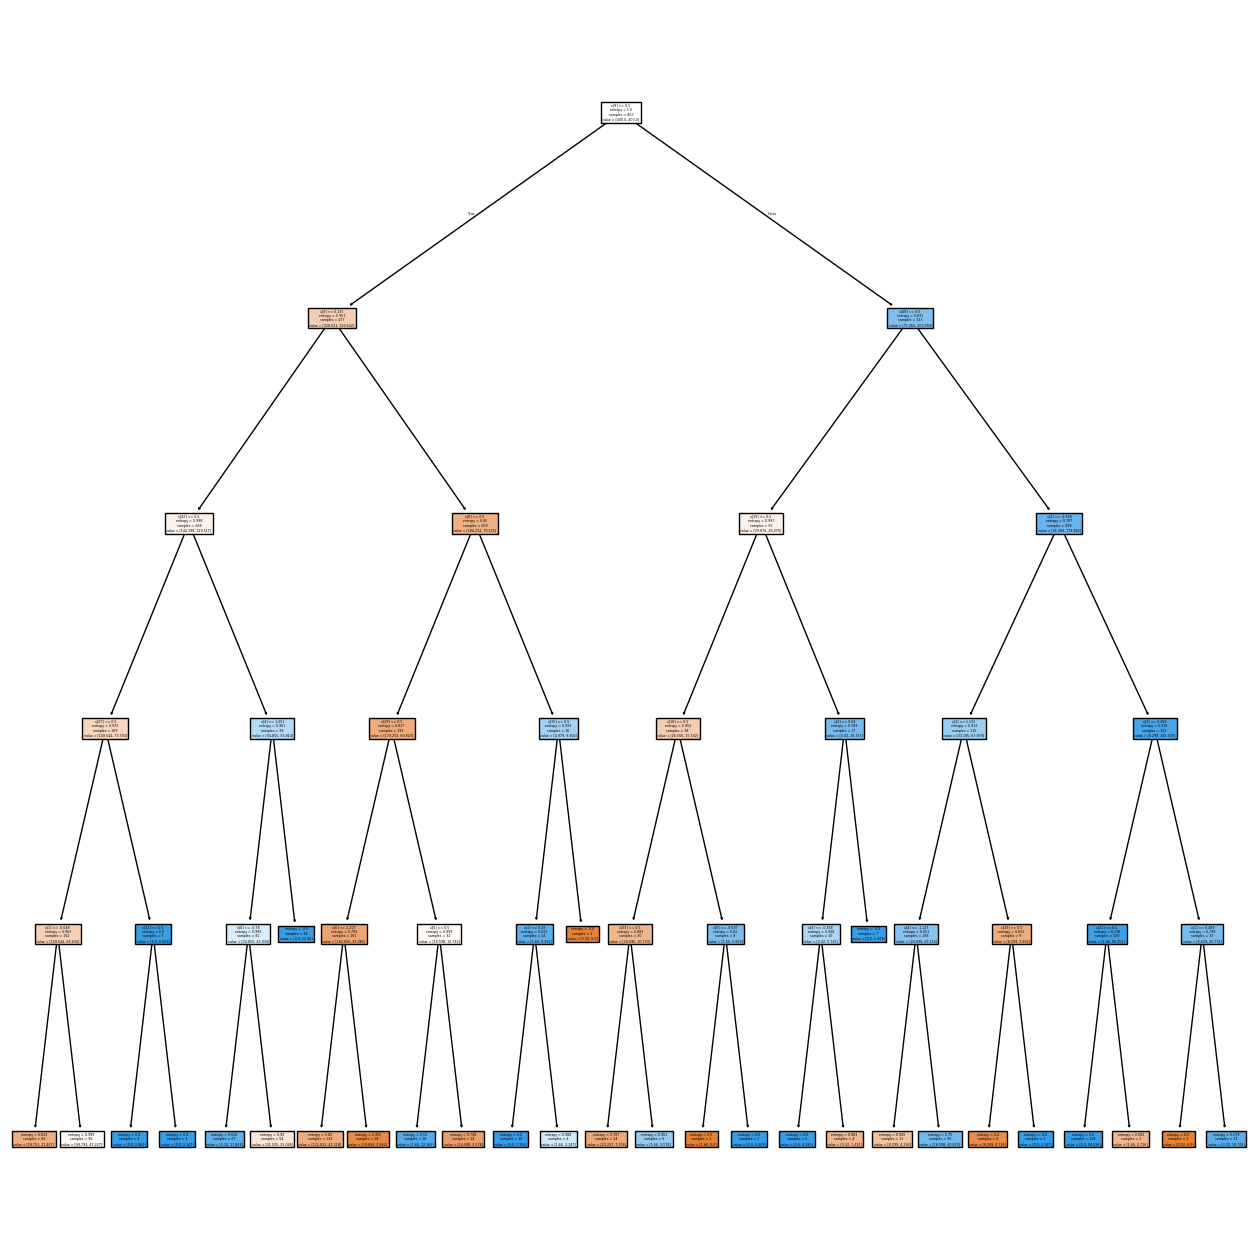

In [122]:
from sklearn import tree
plt.figure(figsize=(16,16))
tree.plot_tree(decision_tree_model, max_depth=5, filled=True)
plt.show()

**Extra**: Any additional discussion and extra work relevant for solving the problem is welcome by the student and will contribute to a better grade.

In [ ]:
# kfold cross validation?